In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install transformers datasets accelerate tensorboard evaluate --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.0
    Uninstalling tensorboard-2.17.0:
      Successfully uninstalled tensorboard-2.17.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. 

In [ ]:
%matplotlib inline

import pickle

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, ConcatDataset
from torch.utils.data import Subset

import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms, models
from torchvision import models

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import transformers
#import datasets
#from datasets import load_dataset
from transformers import ViTFeatureExtractor, ViTForImageClassification
import accelerate
import evaluate
import tensorboard

from transformers import TrainingArguments, Trainer
#provides functions like activations and loss functions
import torch.nn.functional as F

# Get the unlabelled data

In [ ]:
# Load data
with open('/content/drive/My Drive/open_unlabelled_subset_train.pkl', 'rb') as f:
    open_unlabelled_subset_train = pickle.load(f)
with open('/content/drive/My Drive/open_unlabelled_subset_test.pkl', 'rb') as f:
    open_unlabelled_subset_test = pickle.load(f)

/usr/local/lib/python3.10/dist-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [ ]:
#sample from the dataset
sample_img = open_unlabelled_subset_train[0]

#extract image tensor from the sample and print its shape
image_tensor = sample_img[0]
print(sample_img)
print(image_tensor.shape)


(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]]), 7)
torch.Size([3, 224, 224])


In [ ]:
#create DataLoader objects for the open data
open_unlabelled_loader_train = torch.utils.data.DataLoader(open_unlabelled_subset_train, batch_size=64, shuffle=True)

In [ ]:
print(f"Open unlabelled train data size:  {len(open_unlabelled_subset_train)}")
#print(f"Open unlabelled test data size: {len(open_unlabelled_subset_test)}")

print(f"Open unlabelled train data size: {len(open_unlabelled_loader_train)}")
#print(f"Open unlabelled train data size: {len(open_unlabelled_loader_test)}")

Open unlabelled train data size:  30000
Open unlabelled train data size: 469


Labels:  tensor([6, 1, 8, 2, 8, 5, 8, 8, 6, 6, 3, 4, 5, 2, 8, 7, 9, 9, 1, 9, 2, 3, 6, 1,
        3, 0, 7, 5, 2, 0, 1, 3, 6, 8, 7, 8, 0, 5, 1, 9, 7, 8, 6, 8, 0, 0, 5, 1,
        9, 9, 1, 2, 1, 8, 1, 4, 4, 2, 8, 3, 2, 7, 5, 9])
Batch shape:  torch.Size([64, 3, 224, 224])


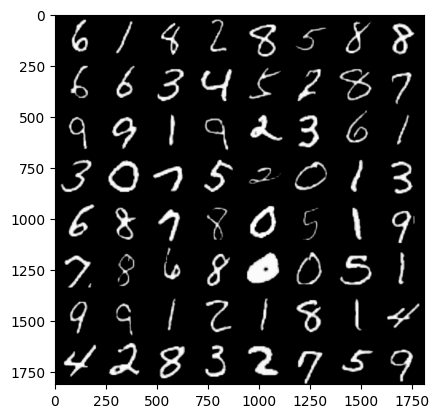

In [ ]:
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

dataiter = iter(open_unlabelled_loader_train)
images, labels = next(dataiter)
# proprietary_loader_train open_unlabelled_loader_train proprietary_loader_test open_unlabelled_loader_test
print('Labels: ', labels)
print('Batch shape: ', images.size())
show_batch(images)

# Get the teacher model trained on MNIST and get predictions of unlabelled data from the teacher model

In [ ]:
# Initialize the teacher model
teacher_model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)
device = torch.device("cuda")
teacher_model.to(device)

# Modify the classifier to fit MNIST's 10 classes
last_layer = teacher_model.heads[-1]
in_features = last_layer.in_features
teacher_model.heads = nn.Linear(in_features=in_features, out_features=10)

# Load the trained model
teacher_model.load_state_dict(torch.load("/content/drive/My Drive/custom_MNIST_vit_b_16_model.pth", map_location=device))
teacher_model.eval()

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 219MB/s]
<ipython-input-16-130a544589be>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded 

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
device = torch.device("cuda")
teacher_model.to(device)

# Data preparation
predicted_labels = []
all_images = []
true_labels = []
data_loader = open_unlabelled_loader_train

with torch.no_grad():
    teacher_model.eval()
    for images, labels in data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = teacher_model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Save predictions and images
        predicted_labels.extend(predicted.cpu().numpy())
        all_images.extend(images.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

In [ ]:
print(predicted_labels)
print(true_labels)

[0, 0, 6, 3, 2, 1, 0, 5, 9, 0, 1, 2, 2, 6, 0, 8, 8, 2, 5, 2, 0, 1, 2, 1, 8, 6, 8, 7, 8, 5, 9, 0, 9, 5, 0, 5, 2, 9, 9, 1, 5, 3, 6, 3, 5, 3, 4, 1, 4, 1, 5, 6, 0, 8, 9, 1, 7, 6, 9, 2, 1, 1, 6, 8, 2, 6, 5, 6, 6, 9, 2, 1, 0, 5, 8, 9, 6, 1, 2, 0, 1, 1, 9, 3, 7, 7, 3, 4, 9, 2, 2, 5, 3, 9, 9, 6, 1, 2, 2, 1, 7, 7, 1, 1, 2, 8, 7, 4, 8, 1, 6, 7, 4, 8, 8, 7, 6, 5, 5, 1, 1, 8, 7, 6, 1, 3, 1, 0, 1, 3, 7, 1, 6, 3, 2, 2, 4, 0, 9, 5, 5, 8, 8, 6, 2, 6, 4, 4, 9, 5, 1, 0, 1, 1, 8, 6, 0, 3, 3, 6, 0, 3, 4, 6, 4, 2, 4, 6, 7, 8, 1, 6, 5, 0, 1, 5, 6, 4, 9, 1, 7, 7, 6, 8, 9, 7, 7, 9, 8, 7, 1, 6, 7, 9, 0, 6, 8, 9, 2, 8, 6, 8, 9, 8, 3, 9, 5, 1, 0, 7, 4, 9, 0, 4, 9, 5, 6, 6, 9, 2, 2, 1, 4, 5, 7, 7, 7, 6, 4, 9, 8, 9, 5, 5, 2, 9, 3, 9, 8, 4, 0, 0, 9, 0, 7, 5, 8, 6, 0, 7, 8, 4, 4, 9, 3, 6, 6, 3, 5, 6, 8, 5, 2, 0, 2, 8, 7, 7, 8, 6, 4, 9, 4, 7, 7, 0, 0, 8, 8, 2, 1, 1, 3, 1, 7, 6, 1, 6, 3, 3, 6, 7, 8, 9, 9, 5, 1, 7, 1, 3, 2, 4, 2, 5, 8, 8, 9, 9, 0, 7, 6, 1, 6, 0, 8, 2, 3, 3, 3, 3, 1, 8, 0, 7, 1, 4, 5, 7, 8, 5, 2, 6, 3, 

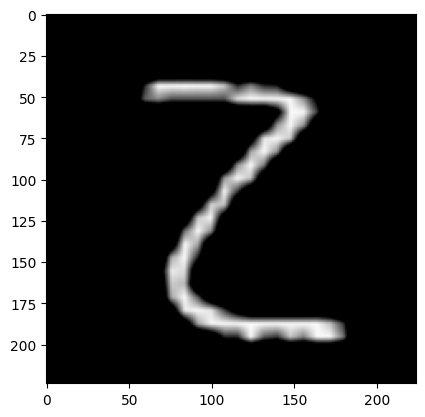

In [ ]:
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))


tensor_from_images = torch.tensor(all_images[11])
show_batch(tensor_from_images)

In [ ]:
# Custom Dataset
class PredictedDataset(torch.utils.data.Dataset):
    def __init__(self, images, predicted_labels, labels):
        self.images = images
        self.predicted_labels = predicted_labels
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        predicted = self.predicted_labels[idx]
        label = self.labels[idx]
        return {'images': torch.tensor(image, dtype=torch.float),
                'predicted_labels': torch.tensor(predicted, dtype=torch.long),
                'labels': torch.tensor(label, dtype=torch.long)}

In [ ]:
#create new dataset using images and their predicted labels
kd_dataset = PredictedDataset(all_images, predicted_labels, true_labels)
#create DataLoader with the new dataset
kd_loader = torch.utils.data.DataLoader(kd_dataset, batch_size=64, shuffle=True)

<ipython-input-22-12ec2bd662ad>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_from_images = torch.tensor(images)


Labels:  tensor([3, 5, 4, 8, 1, 6, 9, 0, 2, 2, 9, 4, 7, 9, 8, 9, 7, 6, 1, 4, 1, 4, 1, 9,
        7, 9, 6, 2, 4, 8, 4, 3, 4, 6, 7, 5, 7, 0, 3, 3, 6, 2, 7, 2, 5, 0, 8, 7,
        0, 5, 8, 5, 4, 2, 8, 2, 7, 5, 4, 4, 8, 2, 6, 8])
predictions:  tensor([3, 5, 4, 8, 1, 6, 9, 0, 2, 2, 9, 4, 7, 9, 8, 9, 7, 6, 1, 4, 1, 4, 1, 9,
        7, 9, 6, 2, 4, 8, 4, 3, 4, 6, 7, 5, 7, 0, 3, 3, 6, 2, 7, 2, 5, 0, 8, 7,
        0, 5, 8, 5, 4, 2, 8, 2, 7, 5, 4, 4, 8, 2, 6, 8])


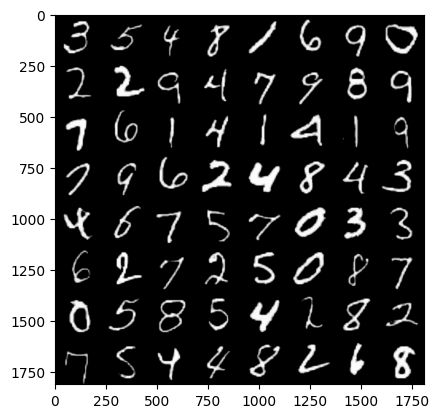

In [ ]:
def show_batch(batch):
    im = torchvision.utils.make_grid(batch)
    plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

dataiter = iter(kd_loader)
images, predicted, labels = next(dataiter)
tensor_from_images = torch.tensor(images)

print('Labels: ', labels)
print('predictions: ', predicted)
show_batch(tensor_from_images)

In [ ]:
#save the new dataset
with open('/content/drive/My Drive/KD_dataset.pkl', 'wb') as f:
    pickle.dump(kd_dataset, f)

# Get the ViT-B/32 student model

In [ ]:
#load the vit_b_32 model
student_model = models.vit_b_32(weights=models.ViT_B_32_Weights.IMAGENET1K_V1)

#modify the classifier to fit MNIST's 10 classes instead of 1000 ImageNet classes
last_layer = student_model.heads[-1]
in_features = last_layer.in_features
student_model.heads = nn.Linear(in_features=in_features, out_features=10)  # 10 classes for MNIST

Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth
100%|██████████| 337M/337M [00:01<00:00, 209MB/s]


# Knowledge distillation

In [ ]:
#custom Trainer Class for Knowledge Distillation
class ImageDistilTrainer(Trainer):
    def __init__(self, teacher_model=None, student_model=None, temperature=2.0, lambda_param=0.5, *args, **kwargs):
        super().__init__(model=student_model, *args, **kwargs)
        self.teacher = teacher_model
        self.student = student_model
        self.loss_function = nn.KLDivLoss(reduction="batchmean")
        self.temperature = temperature
        self.lambda_param = lambda_param
        self.teacher.to(device)
        self.teacher.eval()

    def compute_loss(self, model, inputs, return_outputs=False, return_final_loss=False):
        student_output = model(inputs['images'].to(device))
        #teacher_probs = torch.softmax(inputs['predicted_labels'].to(device), dim=-1)
        soft_teacher = torch.log(inputs['predicted_labels'] / self.temperature)
        soft_student = F.log_softmax(student_output / self.temperature, dim=-1)
        distillation_loss = self.loss_function(soft_student, soft_teacher) * (self.temperature ** 2)
        true_labels = inputs['labels'].to(device)
        student_target_loss = F.cross_entropy(student_output, true_labels)
        loss = (1. - self.lambda_param) * student_target_loss + self.lambda_param * distillation_loss

        if return_outputs and return_final_loss:
            result = (loss, distillation_loss, student_output)
        elif return_outputs:
            result = (distillation_loss, student_output)
        elif return_final_loss:
            result = (loss, distillation_loss)
        else:
            result = distillation_loss

        return result

In [ ]:
from transformers import Trainer, TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir='/content/drive/My Drive/output_dir',
    num_train_epochs=5,
    fp16=True,
    logging_dir="/content/drive/My Drive/logs",
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="tensorboard",
)

In [ ]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    acc = accuracy.compute(references=labels, predictions=np.argmax(predictions, axis=1))
    return {"accuracy": acc["accuracy"]}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()
trainer = ImageDistilTrainer(
    student_model=student_model,
    teacher_model=teacher_model,
    args=training_args,
    train_dataset=kd_dataset,
    eval_dataset=kd_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    temperature=2.0,
    lambda_param=0.5
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [ ]:
trainer.train()

ValueError: The batch received was empty, your model won't be able to train on it. Double-check that your training dataset contains keys expected by the model: x,label_ids,label.

In [ ]:
trainer.evaluate(processed_datasets["test"])

In [ ]:
# Initialize custom trainer
trainer = ImageDistilTrainer(
    teacher_model=teacher_model,
    student_model=student_model,
    temperature=2.0,
    lambda_param=0.5,
    args=training_args,
    train_dataset=kd_dataset,  # Ensure this is correct
    eval_dataset=kd_dataset    # Ensure this is correct
)

# Train the student model
trainer.train()

In [ ]:
from datasets import load_dataset

dataset = load_dataset("beans")

README.md:   0%|          | 0.00/4.95k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/144M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/18.5M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/17.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

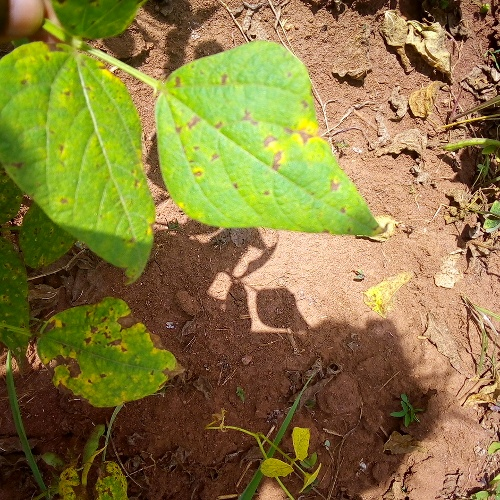

In [ ]:
dataset["train"][0]["image"]

In [ ]:
from transformers import AutoImageProcessor
teacher_processor = AutoImageProcessor.from_pretrained("merve/beans-vit-224")

def process(examples):
    processed_inputs = teacher_processor(examples["image"])
    return processed_inputs

processed_datasets = dataset.map(process, batched=True)

preprocessor_config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

NameError: name 'dataset' is not defined